## Machine Learning Online Class 
##  Exercise 8 Part 1 | Anomaly Detection
Requires : scipy, scikit-learn

### Introduction

In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network.

### Python Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import imread
from scipy.stats import multivariate_normal

%matplotlib inline

### Part 1: Load Example Dataset
We start this exercise by using a small dataset that is easy to visualize <br>
Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine.<br>
This exercise will help us find possibly faulty (or very fast) machines.

In [2]:
data = loadmat('ex8data1.mat')
X = data['X']

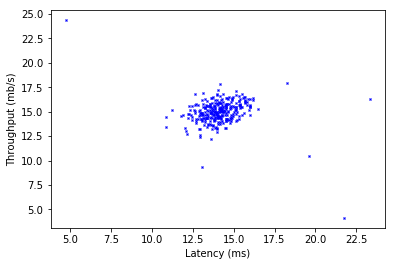

In [3]:
# Visualize example dataset
plt.plot(X[:,0],X[:,1],'bx', ms=2, )
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

### Part 2: Estimate the dataset statistics
For this exercise, we assume a Gaussian distribution for the dataset.<br>
We first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

In [4]:
# Estimate mean and variance (biased estimators)

def estimateGaussian(X): 
    mu = np.mean(X, axis = 0)
    sigma_squared = np.std(X, axis=0)**2
    return mu, sigma_squared

In [5]:
mu, sigma_squared = estimateGaussian(X)

In [6]:
# Return the density of the multivariate
def multivariateGaussian(X, mu, sigma_squared):
    
    # here it is assumed that the features are not correlated and hence the covariance matrix is a diagonal matrix
    return multivariate_normal.pdf(X, mean = mu, cov = sigma_squared.T.dot(np.identity(X.shape[1])))

In [7]:
p = multivariateGaussian(X, mu, sigma_squared)

In [8]:
# Visualize the fit
def visualizeFit(X, mu, sigma_squared):
    
    # Plot data points
    fig = plt.figure(figsize = (6,6))
    plt.plot(X[:,0],X[:,1],'bx', ms=2, )
    
    # Define grid
    xx, yy = np.meshgrid(np.linspace(0, 30, 100), np.linspace(0, 30, 100))
    
    # Compute pdf at each point in grid
    z = multivariateGaussian(np.c_[xx.ravel(),yy.ravel()],mu,sigma_squared).reshape(len(xx),len(yy))
    
    # Plot contours (iso probabilities)
    cp = plt.contour(xx,yy,z,np.logspace(-20,-2, 7), linewidths=1, colors='pink')
    #plt.clabel(cp, fmt = '%.2E')
    
    return cp

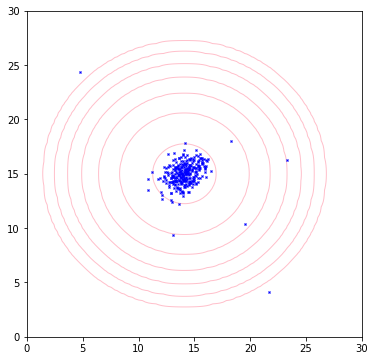

In [9]:
cp = visualizeFit(X, mu, sigma_squared)

### Part 3: Find Outliers
Now we can find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [10]:
# Validation set
Xval = data['Xval']
yval = data ['yval']

pval = multivariateGaussian(Xval, mu, sigma_squared)

In [11]:
def selectThreshold(yval, pval):
    
    epsilon_best = 0
    F1_best = 0
    
    for epsilon in np.linspace(np.min(pval), np.max(pval), 1000):
        
        # Predictions (if proba less than eps then assume anomaly, ie pred =1)
        pred = (pval <= epsilon).astype(int).reshape(-1,1)
        
        tp = np.sum((pred == 1) & (yval == 1))
        tn = np.sum((pred == 0) & (yval == 0))
        fp = np.sum((pred == 1) & (yval == 0))
        fn = np.sum((pred == 0) & (yval == 1))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        F1 = 2* precision * recall /(precision + recall)
        
        if F1 > F1_best:
            F1_best = F1
            epsilon_best = epsilon
        
    return epsilon_best, F1_best        

In [12]:
epsilon_best, F1_best = selectThreshold(yval, pval)

In [13]:
print('Best epsilon found using cross-validation : {:2.4E}'.format(epsilon_best))
print('Best F1 on cross-validation set : {:2.3f}'.format(F1_best))

Best epsilon found using cross-validation : 8.9999E-05
Best F1 on cross-validation set : 0.875


In [14]:
# Find the outliers in the training set and plot the
outliers = np.argwhere(p <= epsilon_best)

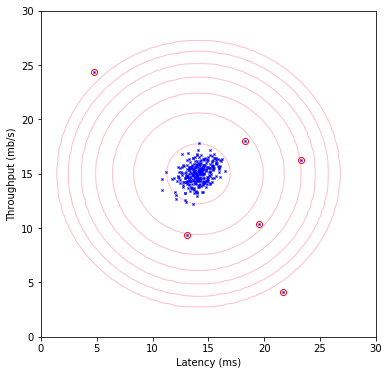

In [15]:
# Visualize outliers
#plt.plot(X[:,0],X[:,1],'bx', ms=2)
cp = visualizeFit(X, mu, sigma_squared)
plt.plot(X[outliers,0],X[outliers,1], 'o', markerfacecolor="None", markeredgecolor='red')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

### Part 4: Multidimensional Outliers
We will now use the code from the previous part and apply it to a harder problem in which more features describe each datapoint and only some features indicate whether a point is an outlier.

In [16]:
# Load the second dataset
data = loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

In [17]:
# Fit training set to gaussian distrib (uncorrelated features)
mu, sigma_squared = estimateGaussian(X)

In [18]:
# probas on training set 
p = multivariateGaussian(X, mu, sigma_squared)

In [19]:
# probas on cross-validation set
pval = multivariateGaussian(Xval, mu, sigma_squared)

In [20]:
# Find the best threshold
epsilon_best, F1_best = selectThreshold(yval, pval)

In [21]:
print('Best epsilon found using cross-validation : {:2.4E}'.format(epsilon_best))
print('Best F1 on cross-validation set : {:2.3f}'.format(F1_best))
print('Number of outliers on training set : {:d}'.format(np.sum(p <= epsilon_best )))

Best epsilon found using cross-validation : 1.3786E-18
Best F1 on cross-validation set : 0.615
Number of outliers on training set : 117
